# Hyperwave SDK Workflow

This notebook demonstrates the complete workflow for FDTD photonics simulations.

**CPU Steps (free, require valid API key):**
1. Build structure recipe from GDSFactory component
2. Build monitors from port information
3. Compute frequency band
4. Solve waveguide mode source

**GPU Step (uses credits):**
5. Run FDTD simulation

**Analysis (free, runs locally):**
6. Analyze results

## Installation

In [1]:
# Install from GitHub
!pip install git+https://github.com/spinsphotonics/hyperwave-community.git --force-reinstall -q

## Configure API

Configure and validate your API key. CPU functions require a valid key (0+ credits).

In [2]:
import hyperwave_community as hwc

# Configure and validate API key
account = hwc.configure_api(
    api_key="7c8aee19-01c9-4400-b5b9-6af0ccf3b118", # 0 credit: d5987b9f-7614-485d-8a4e-b9f49ac4a095
    # api_url defaults to production Cloud Run
)

hwc.get_account_info();

✓ API key validated for: David Qu
  Email: dq4443@gmail.com
  Credits: 429.14

  Welcome back, David Qu!
  dq4443@gmail.com

  API Key:  7c8aee19...
  Credits:  429.14



---
## CPU Steps (Free)

These steps run on Modal CPU and don't consume credits.

### Step 1: Build Structure Recipe

Build a 3D photonic structure from a GDSFactory component.

In [3]:
# PDK Settings (Liu & Poon paper defaults)
COMPONENT_NAME = "mmi2x2_with_sbend"
RESOLUTION_NM = 20          # Grid resolution in nm
N_CORE = 3.48               # Silicon refractive index
N_CLAD = 1.4457             # SiO2 cladding refractive index (sqrt(2.09))
WG_HEIGHT_UM = 0.22         # Waveguide core height in um
TOTAL_HEIGHT_UM = 4.0       # Total simulation height in um (includes cladding)
EXTENSION_LENGTH = 2.0      # Port extension length in um
PADDING = [100, 100, 0, 0]  # Padding cells (left, right, top, bottom)
DENSITY_RADIUS = 3          # Radius for density filtering
VERTICAL_RADIUS = 2.0       # Vertical blur radius

recipe_result = hwc.build_recipe(
    component_name=COMPONENT_NAME,
    resolution_nm=RESOLUTION_NM,
    n_core=N_CORE,
    n_clad=N_CLAD,
    wg_height_um=WG_HEIGHT_UM,
    total_height_um=TOTAL_HEIGHT_UM,
    extension_length=EXTENSION_LENGTH,
    padding=PADDING,
    density_radius=DENSITY_RADIUS,
    vertical_radius=VERTICAL_RADIUS,
)

print(f"Structure dimensions: {recipe_result['dimensions']}")
print(f"Ports: {list(recipe_result['port_info'].keys())}")

Building recipe for mmi2x2_with_sbend...
Recipe built: 1800x350x199 cells
Ports: ['o1', 'o2', 'o3', 'o4']
Structure dimensions: (1800, 350, 199)
Ports: ['o1', 'o2', 'o3', 'o4']


### Step 2: Build Monitors

Building monitors (source: o1)...
Monitors built: ['Input_o1', 'Input_o2', 'Output_o3', 'Output_o4', 'xy_mid']
Generating structure visualization (axis=z)...
Visualization generated: [1800, 350, 199]


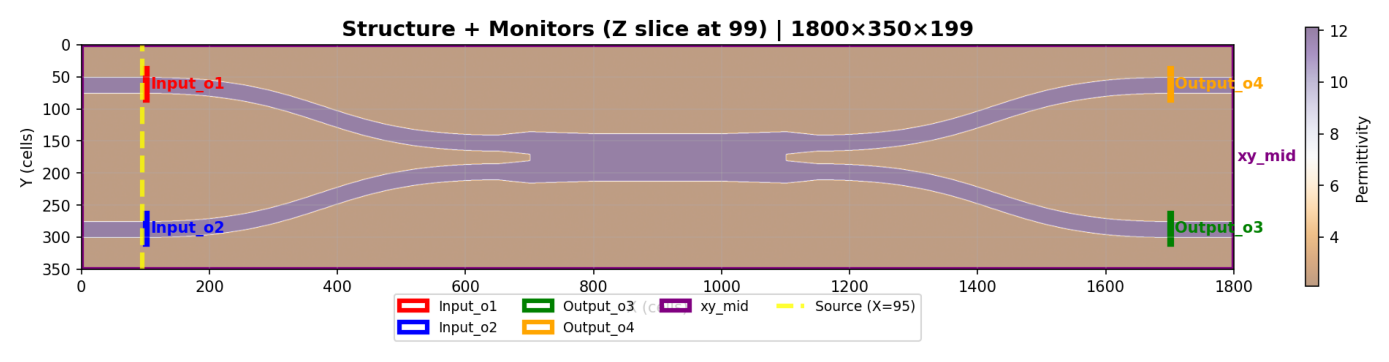

Monitors: ['Input_o1', 'Input_o2', 'Output_o3', 'Output_o4', 'xy_mid']
Source port: Input_o1
Source position: x=95


In [4]:
# Source port (which port to inject light from)
SOURCE_PORT = "o1"          # Input port name

monitor_result = hwc.build_monitors(
    port_info=recipe_result['port_info'],
    dimensions=recipe_result['dimensions'],
    source_port=SOURCE_PORT,
    structure_recipe=recipe_result['recipe'],  # Required for visualization
    show_structure=True,  # Show structure plot with monitors
)

print(f"Monitors: {list(monitor_result['monitor_names'].keys())}")
print(f"Source port: {monitor_result['source_port_name']}")
print(f"Source position: x={monitor_result['source_position']}")

### Step 3: Compute Frequency Band

In [5]:
# Wavelength settings
WL_CENTER_UM = 1.55         # Center wavelength in um
N_FREQS = 1                 # Number of frequency points

freq_result = hwc.compute_freq_band(
    wl_min_um=WL_CENTER_UM,
    wl_max_um=WL_CENTER_UM,
    n_freqs=N_FREQS,
    resolution_um=recipe_result['resolution_um'],
)

print(f"Frequency band: {freq_result['freq_band']}")
print(f"Wavelengths: {freq_result['wavelengths_um']}")

Computing freq band: 1.55-1.55 um (1 points)...
Freq band computed: [0.08107335880231724, 0.08107335880231724, 1.0]
Frequency band: (0.08107335880231724, 0.08107335880231724, 1.0)
Wavelengths: [1.55]


### Step 4: Solve Waveguide Mode

Solving mode at x=95...
Mode solved: n_eff=N/A
Generating mode source visualization...
Mode visualization generated: shape=[1, 6, 1, 100, 100], max_intensity=6.25e-03


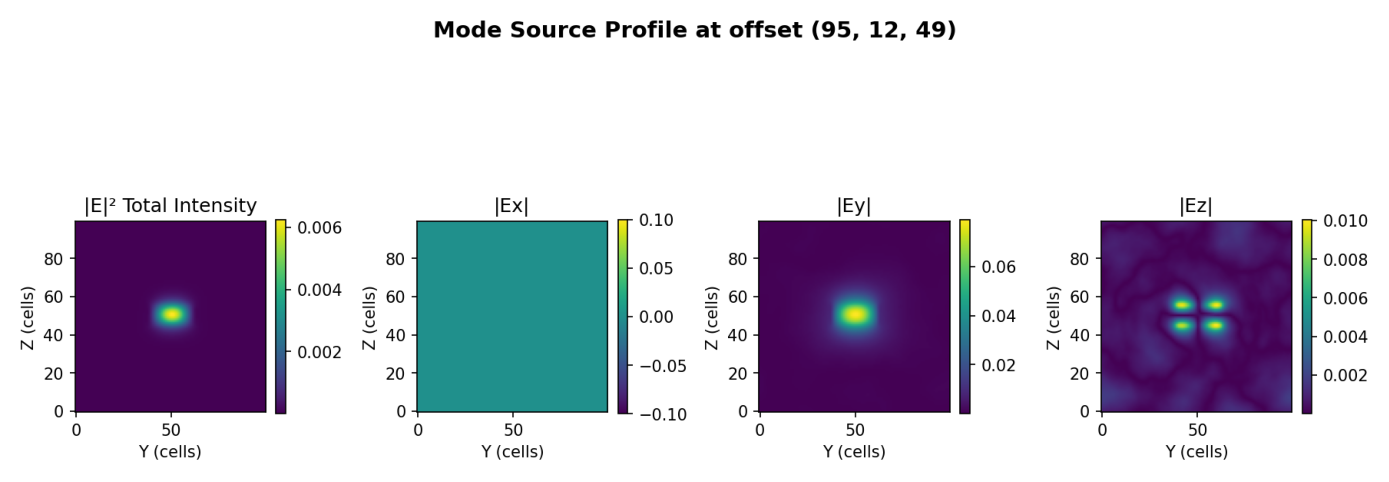

Source field shape: (1, 6, 1, 100, 100)
Source offset: (95, 12, 49)


In [6]:
# Mode settings
MODE_NUM = 0                # Mode number (0 = fundamental TE mode)

source_result = hwc.solve_mode_source(
    density_core=recipe_result['density_core'],
    density_clad=recipe_result['density_clad'],
    source_x_position=monitor_result['source_position'],
    mode_bounds=monitor_result['mode_bounds'],
    layer_config=recipe_result['layer_config'],
    eps_values=recipe_result['eps_values'],
    freq_band=freq_result['freq_band'],
    mode_num=MODE_NUM,
    show_mode=True,  # Show mode visualization (default)
)

print(f"Source field shape: {source_result['source_field'].shape}")
print(f"Source offset: {source_result['source_offset']}")

---
## GPU Step (Uses Credits)

### Step 5: Run FDTD Simulation

This step runs on Modal GPU and consumes credits.

In [7]:
# Simulation settings
NUM_STEPS = 20000           # Maximum FDTD time steps
GPU_TYPE = "B200"           # GPU type: "B200", "H200", "H100", "A100", etc.

# Get Bayesian-optimized absorber parameters (scaled for current resolution)
absorber_params = hwc.get_optimized_absorber_params(
    resolution_nm=RESOLUTION_NM,
    wavelength_um=WL_CENTER_UM,
    structure_dimensions=recipe_result['dimensions'],
)
print(f"Absorber params (BO-optimized for {RESOLUTION_NM}nm):")
print(f"  Widths: {absorber_params['absorption_widths']}")
print(f"  Coefficient: {absorber_params['absorber_coeff']:.6f}")

# Run simulation - pass results from previous steps (SDK handles packaging)
results = hwc.run_simulation(
    device_type=COMPONENT_NAME,
    recipe_result=recipe_result,
    monitor_result=monitor_result,
    freq_result=freq_result,
    source_result=source_result,
    num_steps=NUM_STEPS,
    gpu_type=GPU_TYPE,
    absorption_widths=absorber_params['absorption_widths'],
    absorption_coeff=absorber_params['absorber_coeff'],
    convergence="default",  # or "quick", "thorough", "full"
)

print(f"\nSimulation time: {results['sim_time']:.1f}s")
print(f"Total execution time: {results['total_time']:.1f}s")
if results.get('converged'):
    print(f"Converged at step: {results['convergence_step']}")


---
## Step 6: Analyze Results

In [8]:
import matplotlib.pyplot as plt

# === TRANSMISSION ANALYSIS ===
transmission = hwc.analyze_transmission(
    results,
    input_monitor="Input_o1",
    output_monitors=["Output_o3", "Output_o4"],
)

# Display results
print(f"\nInput power: {transmission['power_in']:.4f}")
print(f"Total transmission: {transmission['total_transmission']:.4f}")
print(f"Excess loss: {transmission['excess_loss_dB']:.2f} dB")

Transmission Analysis (Input: Input_o1)
Monitor              Transmission         dB
------------------------------------------------------------
Output_o3                  0.4670      -3.31
Output_o4                  0.4787      -3.20
------------------------------------------------------------
Total                      0.9457      -0.24

Input power: 0.0425
Total transmission: 0.9457
Excess loss: -0.24 dB


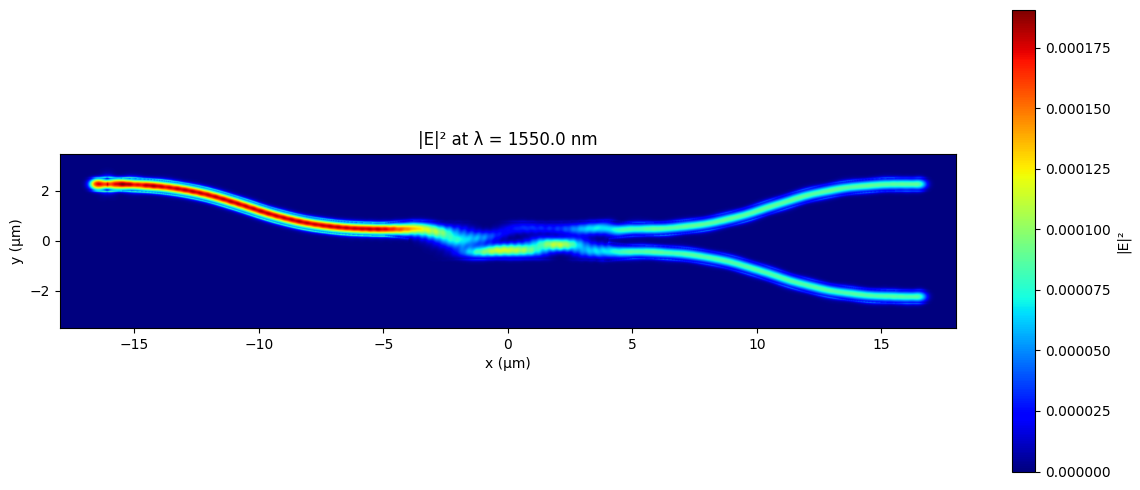

In [9]:
# === FIELD INTENSITY VISUALIZATION ===
# Note: Requires xy_mid monitor data from simulation

try:
    field_data = hwc.get_field_intensity_2d(
        results,
        monitor_name='xy_mid',
        dimensions=recipe_result['dimensions'],
        resolution_um=recipe_result['resolution_um'],
        freq_band=freq_result['freq_band'],
    )

    plt.figure(figsize=(12, 5))
    plt.imshow(
        field_data['intensity'],
        origin='upper',
        extent=field_data['extent'],
        cmap='jet',
        aspect='equal'
    )
    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(f"|E|² at λ = {field_data['wavelength_nm']:.1f} nm")
    plt.colorbar(label='|E|²')
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"Field visualization not available: {e}")
    print("Note: xy_mid monitor may not be supported by early_stopping endpoint yet.")

---
## Summary

| Step | Function | Cost | Notes |
|------|----------|------|-------|
| 1 | `build_recipe()` | Free | Creates structure recipe from GDSFactory component |
| 2 | `build_monitors()` | Free | Structure plot (toggle: `show_structure`) |
| 3 | `compute_freq_band()` | Free | Converts wavelengths to frequency band |
| 4 | `solve_mode_source()` | Free | Mode profile (toggle: `show_mode`) |
| 5 | `run_simulation()` | Credits | GPU FDTD simulation |
| 6 | `analyze_transmission()` | Free | Local Poynting vector calculation |

All CPU functions require a **valid API key** but don't consume credits.

### Convergence Presets
- `"quick"` - Fast simulations, fewer stability checks (2 checks at 2000 step intervals)
- `"default"` - Balanced approach (3 checks at 1000 step intervals)
- `"thorough"` - Conservative (5 checks, min 5000 steps before checking)
- `"full"` - No early stopping, run all steps

All presets use **1% relative threshold** for convergence detection.

### Analysis Functions (local, no API calls)
- `analyze_transmission(results)` - Full transmission analysis with table output
- `get_field_intensity_2d(results)` - Extract |E|² intensity for plotting (requires 2D monitor)